In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from seaborn import *
from matplotlib.ticker import ScalarFormatter
from sklearn import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import  mean_absolute_error
import shap

pd.set_option('display.max_columns', None)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Create DataFrame, Handling Null Values, Filtering Year

In [2]:
# Load CSV files
races_df = pd.read_csv('races.csv')[['raceId', 'year', 'round', 'circuitId', 'name', 'date']]
lap_times_df = pd.read_csv('lap_times.csv')[['raceId', 'driverId', 'lap', 'milliseconds']]
results_df = pd.read_csv('results.csv')[['raceId', 'driverId', 'grid', 'position','positionOrder', 'points', 'laps', 'milliseconds', 'rank']]
drivers_df = pd.read_csv('drivers.csv')[['driverId', 'driverRef']]
pit_stops_df = pd.read_csv('pit_stops.csv')[['raceId', 'driverId', 'lap', 'milliseconds']]

# Merge the DataFrames
merged_df = pd.merge(races_df, lap_times_df, on='raceId')
merged_df = pd.merge(merged_df, results_df, on=['raceId', 'driverId'])
merged_df = pd.merge(merged_df, drivers_df, on='driverId')

# Merge pit_stops_df based on raceId, driverId, and lap
merged_df = pd.merge(merged_df, pit_stops_df, on=['raceId', 'driverId', 'lap'], how='left')

# Replace NaN values with 0
merged_df.fillna(0, inplace=True)

# Rename columns
merged_df.rename(columns={'grid':'starting_pos','positionOrder':'resulted_pos','name': 'race_name','milliseconds_x': 'lap_time_ms', 'laps': 'race_laps','milliseconds_y': 'race_time_ms', 'milliseconds': 'pitstop_ms'}, inplace=True)

# Filter data for the years 2017 to 2023
merged_df = merged_df[(merged_df['year'] >= 2017) & (merged_df['year'] <= 2023)]

# Delete Duplicates
merged_df = merged_df.drop_duplicates()

# Display the resulting DataFrame
merged_df.head()


,raceId,year,round,circuitId,race_name,date,driverId,lap,lap_time_ms,starting_pos,position,resulted_pos,points,race_laps,race_time_ms,rank,driverRef,pitstop_ms
10506,969,2017,1,1,Australian Grand Prix,2017-03-26,1,1,94404,1,2,2,18.0,57,5061647,6,hamilton,0.0
10507,969,2017,1,1,Australian Grand Prix,2017-03-26,1,2,89638,1,2,2,18.0,57,5061647,6,hamilton,0.0
10508,969,2017,1,1,Australian Grand Prix,2017-03-26,1,3,89119,1,2,2,18.0,57,5061647,6,hamilton,0.0
10509,969,2017,1,1,Australian Grand Prix,2017-03-26,1,4,89044,1,2,2,18.0,57,5061647,6,hamilton,0.0
10510,969,2017,1,1,Australian Grand Prix,2017-03-26,1,5,88786,1,2,2,18.0,57,5061647,6,hamilton,0.0


In [3]:
# Make df numerical columns
numeric_columns = merged_df.select_dtypes(include=['float64', 'int64'])
numeric_columns = numeric_columns.head(70000)
columns_to_remove = ['circuitId', 'raceId', 'driverId']
numeric_columns = numeric_columns.drop(columns=columns_to_remove)

In [4]:
correlation_with_lap_time = numeric_columns.corr()['lap_time_ms'].sort_values(ascending=False)
print(correlation_with_lap_time)

lap_time_ms     1.000000
pitstop_ms      0.217455
year            0.018369
resulted_pos    0.007312
round           0.003082
starting_pos    0.002503
points         -0.006658
lap            -0.091464
race_laps      -0.162546
Name: lap_time_ms, dtype: float64


In [5]:
numeric_columns.skew()

year             0.373510
round            0.155919
lap              0.249590
lap_time_ms     26.878123
starting_pos     0.235073
resulted_pos     0.276754
points           0.909244
race_laps       -0.866550
pitstop_ms      30.140074
dtype: float64

Outlier Removal

In [6]:
Q1 = numeric_columns.quantile(0.2)
Q3 = numeric_columns.quantile(0.98)
IQR = Q3 - Q1
numeric_columns = numeric_columns[~((numeric_columns<(Q1-1.5*IQR)) | (numeric_columns>(Q3+1.5*IQR))).any(axis=1)]
numeric_columns.head()

,year,round,lap,lap_time_ms,starting_pos,resulted_pos,points,race_laps,pitstop_ms
10506,2017,1,1,94404,1,2,18.0,57,0.0
10507,2017,1,2,89638,1,2,18.0,57,0.0
10508,2017,1,3,89119,1,2,18.0,57,0.0
10509,2017,1,4,89044,1,2,18.0,57,0.0
10510,2017,1,5,88786,1,2,18.0,57,0.0


Machine Learning!!!

In [8]:
x = numeric_columns[['year','round','lap','starting_pos', 'resulted_pos', 'points', 'race_laps', 'pitstop_ms']]
y = numeric_columns['lap_time_ms']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Create and train a Linear Regression model
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

Robust Scalar

In [9]:
# Create and apply RobustScaler
scaler_robust = RobustScaler()
x_train_robust = scaler_robust.fit_transform(x_train)
x_test_robust = scaler_robust.transform(x_test)

# Create and train models with robustly scaled data
models_robust = {
    "Linear Regression": LinearRegression(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "K-Nearest Neighbors Regressor": KNeighborsRegressor(),
    "Support Vector Regressor": SVR(),
    "Gradient Boosting Regressor": GradientBoostingRegressor()
}

for model_name, model in models_robust.items():
    # Train the model
    model.fit(x_train_robust, y_train)
    
    # Make predictions on the test set
    predictions_robust = model.predict(x_test_robust)
    
    # Calculate MSE and R2
    mse_robust = mean_squared_error(y_test, predictions_robust)
    r2_robust = r2_score(y_test, predictions_robust)
    
    # Print results
    print(f"{model_name} with RobustScaler - MSE: {mse_robust}, R2: {r2_robust}")


Linear Regression with RobustScaler - MSE: 196309187.12596974, R2: 0.3527064325298659
Decision Tree Regressor with RobustScaler - MSE: 38731828.00798446, R2: 0.8722888954257644
Random Forest Regressor with RobustScaler - MSE: 25384753.457173243, R2: 0.9162984276731806
K-Nearest Neighbors Regressor with RobustScaler - MSE: 88183059.49560638, R2: 0.7092325223948167
Support Vector Regressor with RobustScaler - MSE: 304866289.1303714, R2: -0.005240716349915742
Gradient Boosting Regressor with RobustScaler - MSE: 132974269.18763761, R2: 0.5615417172046695


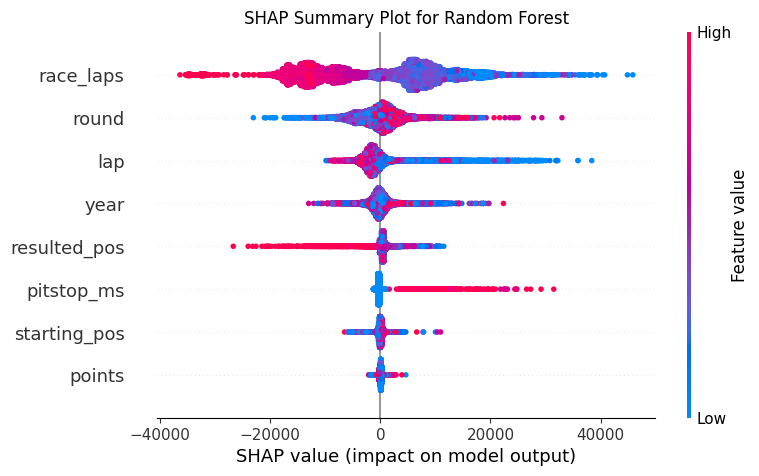

In [11]:
# Train the Random Forest model
random_forest_model = RandomForestRegressor()
random_forest_model.fit(x_train_robust, y_train)

# Create a SHAP explainer
explainer = shap.TreeExplainer(random_forest_model)

# Get SHAP values for the test set
shap_values = explainer.shap_values(x_test_robust)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, x_test_robust, feature_names=x_test.columns, show=False)
plt.title("SHAP Summary Plot for Random Forest")
plt.show()